In [2]:
# Importing necessary libraries
import os
import cv2
import math
import numpy as np
import pandas as pd


import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [3]:
# Reading input path
INPUT_PATH = r"C:/Users/suhas/Downloads/FER 2013 dataset/"

In [4]:
# count of emotions.
total_images = 0
for category in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + category + "/"):
        count += 1
        total_images += 1
    print(f"{category} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

Angry has 2832 number of images
disgust has 380 number of images
fear has 2535 number of images
Happy has 6834 number of images
Neutral has 4295 number of images

total images are 16876


In [5]:
# Removing disgust emotion
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [6]:
#Loading images into an array
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for category in os.listdir(INPUT_PATH):
    if category in TOP_EMOTIONS:
        label_to_text[e] = category
        for f in os.listdir(INPUT_PATH + category + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + category + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {category} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Angry images to numpy arrays
loaded all fear images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [7]:
# Labels are converted to textual format
label_to_text

{0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}

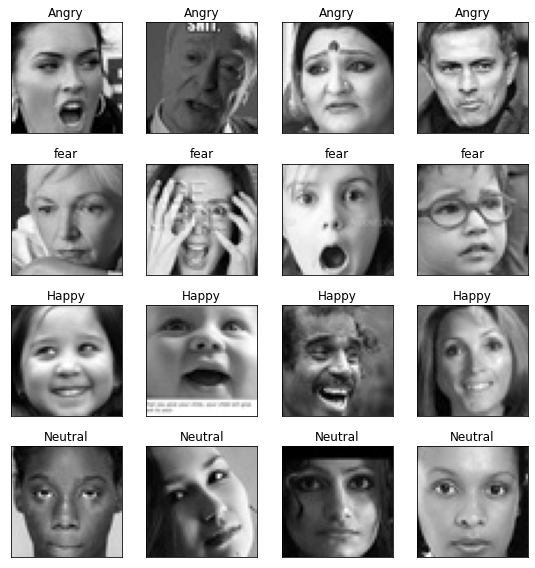

In [8]:
#Plot of emotions
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [9]:
#Converting class vector to binary class matrix
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16496, 4)

In [10]:
#Normalizing the data
img_arr = img_arr / 255.

In [11]:
# Splitting Data into test and train
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [12]:
# Defining width, height, depth, and number of classes
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [13]:
#Defining transfer learning model
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                                      

In [15]:
for layer in model.layers[:15]:
    layer.trainable = False
#Augumenting Training images
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
datagen.fit(X_train)

In [16]:
"""
Using two callbacks one is `early stopping` for avoiding overfitting of training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler]

In [47]:
batch_size = 32
epochs = 40

optimizer = optimizers.Adam(0.01)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=datagen.flow(X_test, y_test,batch_size= batch_size),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/40
463/463 [==============================] - 68s 143ms/step - loss: 0.7453 - accuracy: 0.7076 - val_loss: 0.9405 - val_accuracy: 0.6570 - lr: 0.0100
Epoch 2/40
463/463 [==============================] - 71s 153ms/step - loss: 0.7316 - accuracy: 0.7141 - val_loss: 2.1329 - val_accuracy: 0.5206 - lr: 0.0100
Epoch 3/40
463/463 [==============================] - 73s 156ms/step - loss: 0.7306 - accuracy: 0.7155 - val_loss: 0.8233 - val_accuracy: 0.6582 - lr: 0.0100
Epoch 4/40
463/463 [==============================] - 73s 158ms/step - loss: 0.7166 - accuracy: 0.7193 - val_loss: 1.0212 - val_accuracy: 0.6297 - lr: 0.0100
Epoch 5/40
463/463 [==============================] - 68s 146ms/step - loss: 0.7092 - accuracy: 0.7205 - val_loss: 0.8193 - val_accuracy: 0.6758 - lr: 0.0100
Epoch 6/40
463/463 [==============================] - 68s 146ms/step - loss: 0.7008 - accuracy: 0.7259 - val_loss: 0.9339 - val_accuracy: 0.6382 - lr: 0.0100
Epoch 7/40
463/463 [==============================] 

In [48]:
#Fetching accuracy and loss of test and train dataset
score = model.evaluate(X_test, y_test,verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
test_image = X_test[0:1]
print (test_image.shape)

score = model.evaluate(X_train, y_train,verbose=0) 
print('Train Loss:', score[0])
print('Train accuracy:', score[1])
train_image = X_train[0:1]
print (train_image.shape)

Test Loss: 0.6728285551071167
Test accuracy: 0.7539393901824951
(1, 48, 48, 3)
Train Loss: 0.4814305305480957
Train accuracy: 0.8146302103996277
(1, 48, 48, 3)


In [49]:
model.save("model.h5")
print('Model saved in disk')

Model saved in disk


{0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       283
           1       0.66      0.56      0.60       253
           2       0.89      0.87      0.88       684
           3       0.66      0.78      0.71       430

    accuracy                           0.75      1650
   macro avg       0.72      0.71      0.71      1650
weighted avg       0.76      0.75      0.75      1650



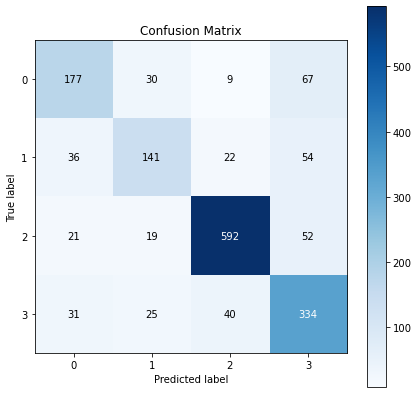

In [50]:
import scikitplot
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest = np.argmax(y_test,axis=1)
print(label_to_text)
scikitplot.metrics.plot_confusion_matrix(ytest, yhat_test,figsize=(7,7))
pyplot.savefig("model_confusion_matrix.jpg")
print(classification_report(ytest, yhat_test))

# Confusion matrix indicates that the model performs better on Happy and Neutral emotion labels